# Transformer Library by Hugging Faces and Torch 1.7.1 for using cuda

In [1]:
!pip install -qq transformers
!pip install torch==1.7.1

     |████████████████████████████████| 2.6 MB 13.4 MB/s 
     |████████████████████████████████| 636 kB 41.4 MB/s 
     |████████████████████████████████| 3.3 MB 44.0 MB/s 
     |████████████████████████████████| 895 kB 40.4 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.


# Necessary Imports


In [2]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import os

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from shutil import copyfile
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import f1_score, accuracy_score

from google.colab import drive

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data Exploration

In [3]:
train_df = pd.read_csv('/content/train.csv')
dev_df = pd.read_csv('/content/dev.csv')
test_df = pd.read_csv('/content/test.csv')
aug_df = pd.read_csv('/content/filtered_augemented_data.csv')

In [4]:
train_df.shape

(8000, 6)

In [5]:
aug_df.shape

(10761, 2)

Adding augumented data to train_df

In [6]:
train_df.drop(['id','humor_rating','humor_controversy', 'offense_rating'] , inplace=True, axis=1)
train_df = pd.concat([train_df, aug_df])

Shape after adding the augmented data

In [7]:
train_df.shape

(18761, 2)

In [8]:
train_df.head()

,text,is_humor
0,TENNESSEE: We're the best state. Nobody even c...,1
1,A man inserted an advertisement in the classif...,1
2,How many men does it take to open a can of bee...,1
3,Told my mom I hit 1200 Twitter followers. She ...,1
4,Roses are dead. Love is fake. Weddings are bas...,1


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18761 entries, 0 to 10760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      18761 non-null  object
 1   is_humor  18761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 439.7+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Humorous'), Text(0, 0, 'Non-Humorous')]

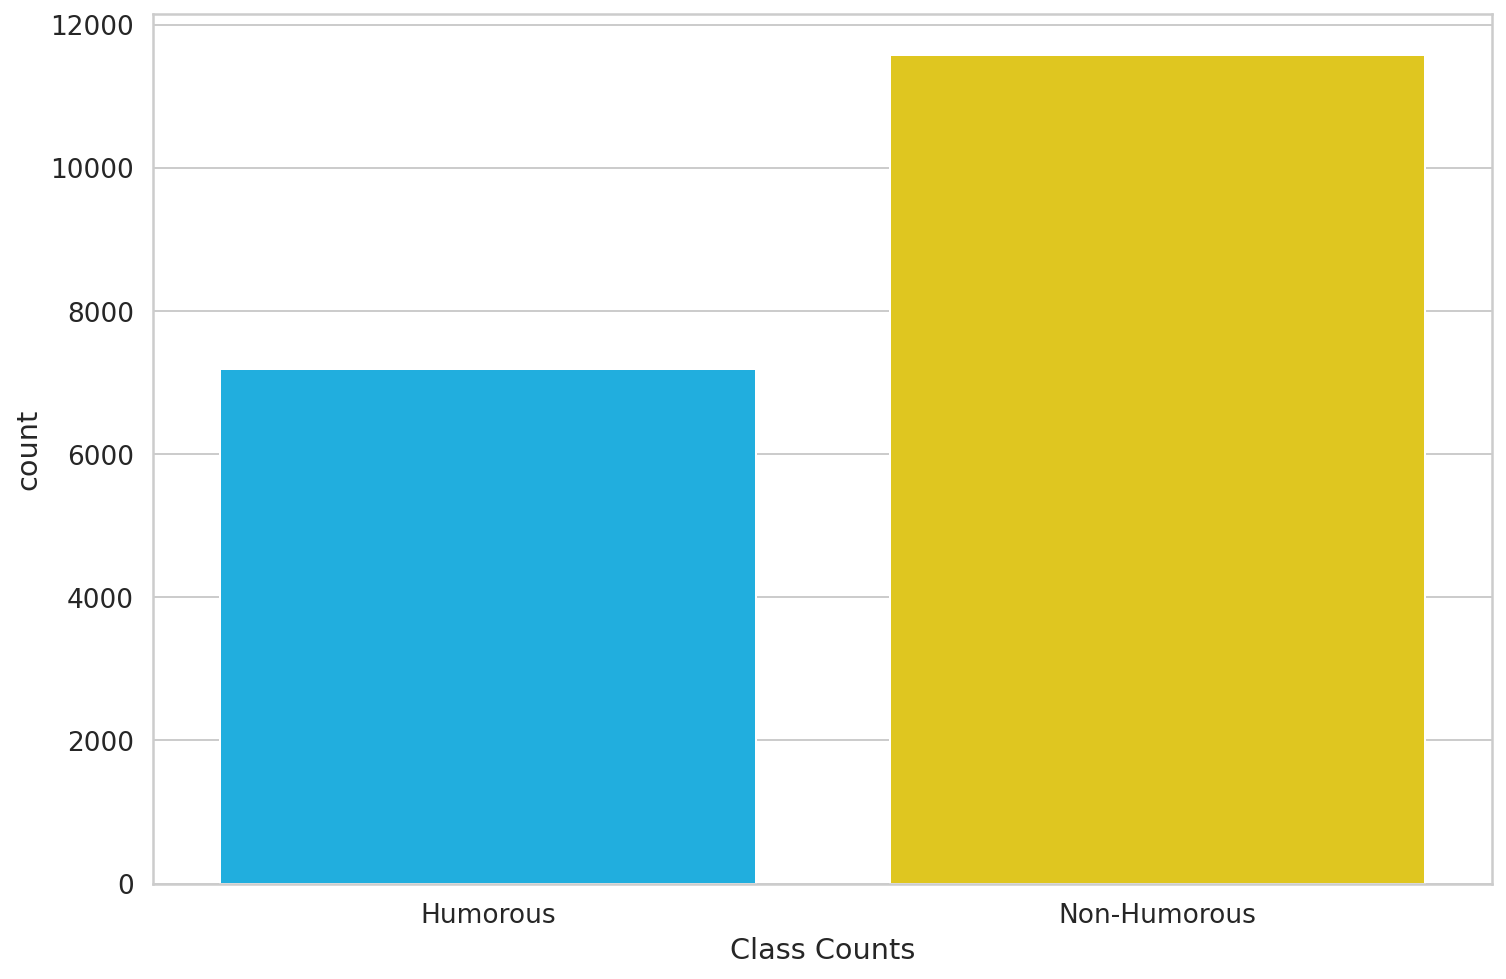

In [10]:
class_names = ['Humorous', 'Non-Humorous']
ax = sns.countplot(train_df.is_humor)
plt.xlabel('Class Counts')
ax.set_xticklabels(class_names)

# Data Preprocessing

In [11]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

Loading a pre-trained RobertaTokenizer:

In [12]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
token_lens = []

for txt in train_df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


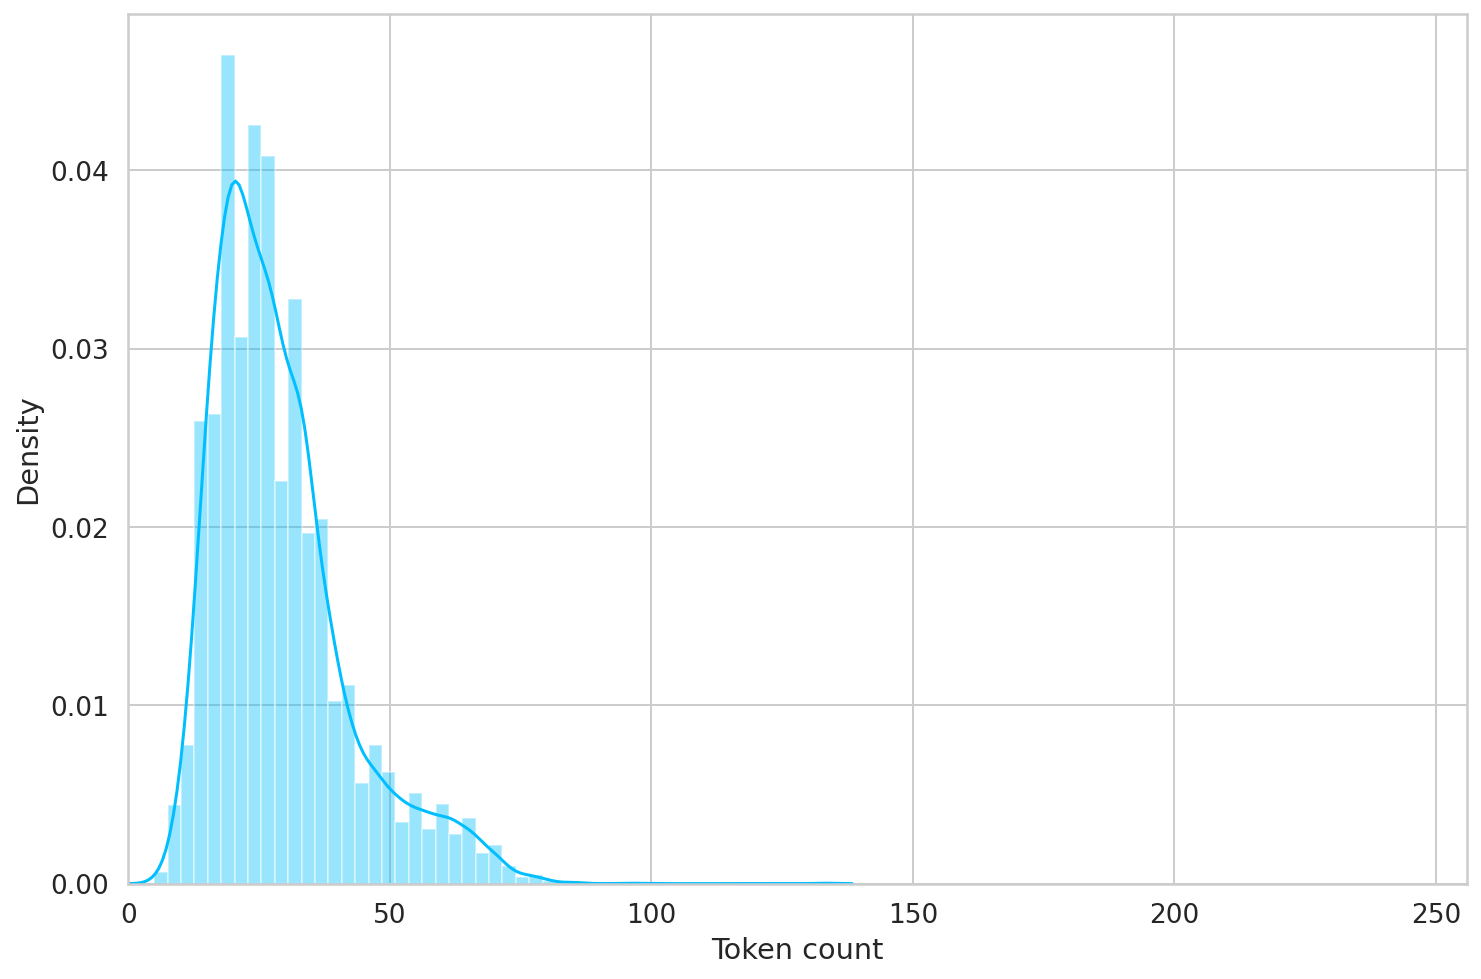

In [14]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the texts contains less than 100 tokens, so choosing a maximum length of 100.

In [15]:
MAX_LEN = 100

Creating a custom dataset class.

In [16]:
class CustomDataset(Dataset):

  def __init__(self, text, labels, tokenizer, max_len):
    self.text = text
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding= 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation= True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'true_label': torch.tensor(label, dtype=torch.long)
    }

 For computing and storing the average and current value

In [17]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Helper function for data loader

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CustomDataset(
    text=df.text.to_numpy(),
    labels=df.is_humor.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=16
  )

In [19]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(dev_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

# Humour Detection with Roberta

Loading the Roberta  Model.

In [20]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier on top of roberta

In [21]:
class MyClassifier(nn.Module):

  def __init__(self, n_classes):
    super(MyClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [22]:
model = MyClassifier(2)
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

In [23]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Helper function for training model for one epoch

In [24]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  loss_avg = AverageMeter()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["true_label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    t = targets.float().view(-1,1) #[32,1]
    
    loss = loss_fn(outputs[:, 0:2], t[:, 0].long())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    loss_avg.update(loss.item(), targets.shape[0])

  return loss_avg.avg

Helper function to evaluate the model.

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  loss_avg = AverageMeter()
  o_   = torch.tensor([]).to(device) #use for metrics
  t_   = torch.tensor([]).to(device)

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["true_label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      t = targets.float().view(-1,1) #[128,1] batch size
      loss = loss_fn(outputs[:, 0:2], t[:, 0].long())

      # EVALUATE
      max_o = torch.argmax(outputs[:, 0:2], dim=1).view(-1,1)
      max_o = max_o.detach()
      o_    = torch.cat((o_, max_o)  , 0) #float and append
      t_    = torch.cat((t_, targets), 0)
      loss_avg.update(loss.item(), targets.shape[0])

    o_ = o_.cpu().numpy()
    t_ = t_.view(-1,1)# change shape same as o_
    t_ = t_.cpu().numpy()
    fscore = f1_score(t_[:, 0], o_[:, 0])
    accuracy= accuracy_score(t_[:, 0], o_[:, 0])

    return loss_avg.avg, [fscore, accuracy]

Training Loop

In [26]:
train_loss_arr = []
val_loss_arr = []
val_metrics = [] #[f1-score , accuracy]

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_df)
  )
  print("Training Loss : ", train_loss)
  
  val_loss, metrics = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(dev_df)
  )
  print("Validation Loss : ", val_loss)
  train_loss_arr.append(train_loss)
  val_loss_arr.append(val_loss)
  val_metrics.append(metrics)

Epoch 1/5
----------
Training Loss :  0.21878259277113096
Validation Loss :  0.2654038760662079
Epoch 2/5
----------
Training Loss :  0.06317499396236083
Validation Loss :  0.4416772302389145
Epoch 3/5
----------
Training Loss :  0.02654981187156418
Validation Loss :  0.6177279815673828
Epoch 4/5
----------
Training Loss :  0.010841827461868169
Validation Loss :  0.6665016701221466
Epoch 5/5
----------
Training Loss :  0.005296578835399778
Validation Loss :  0.6595710691194981


(0.0, 1.0)

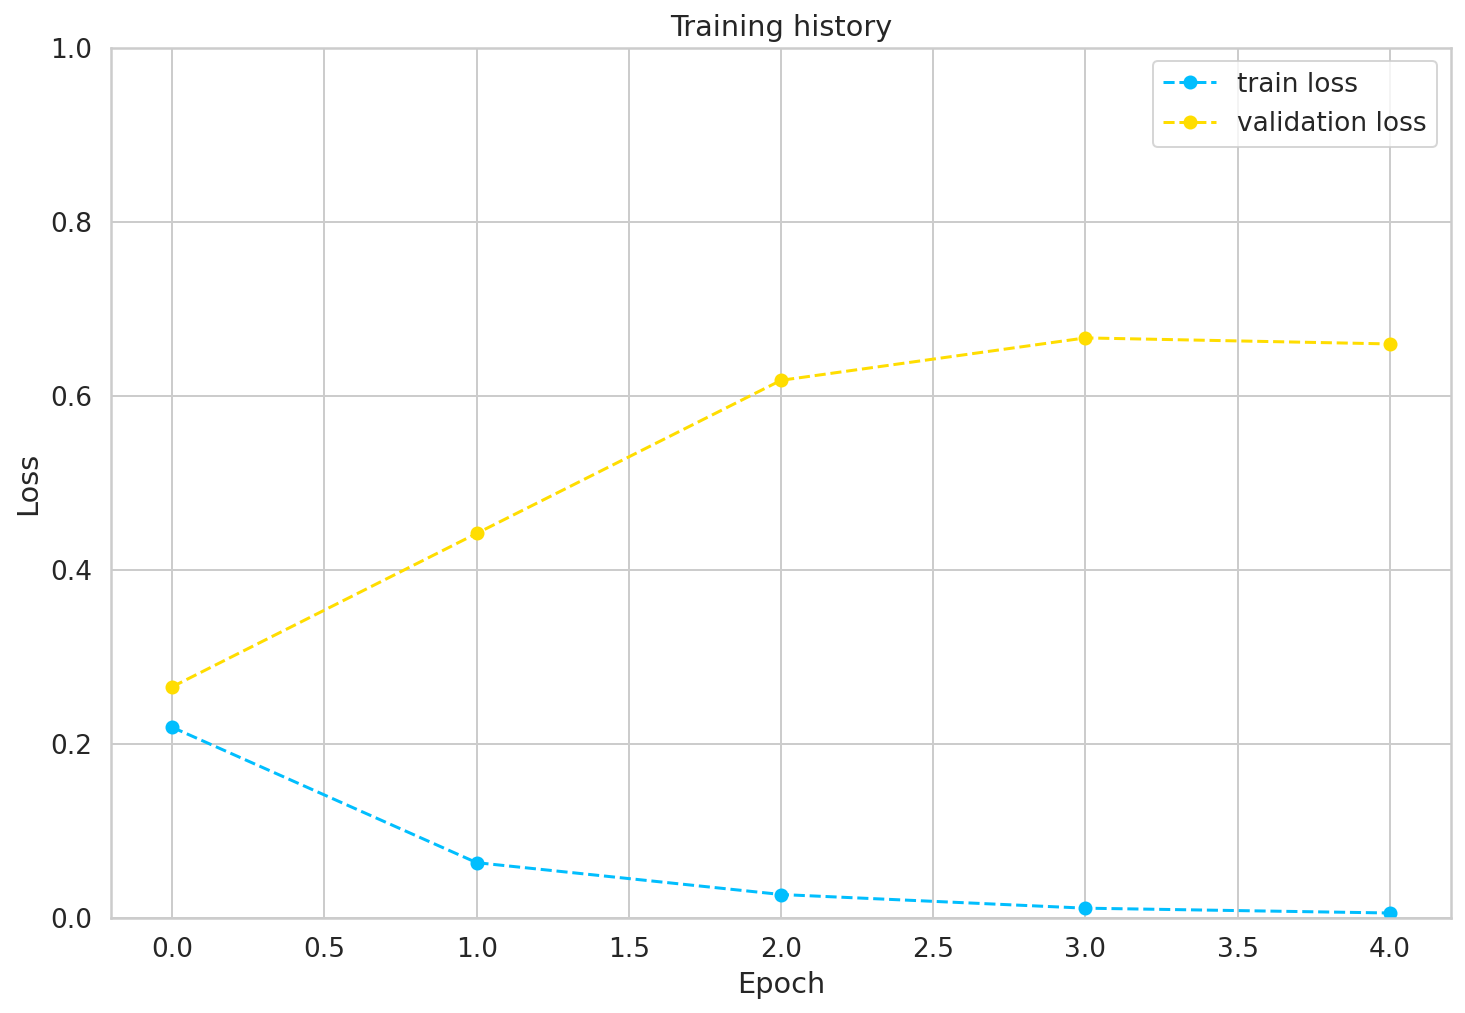

In [27]:
plt.plot(train_loss_arr, "--o", label='train loss')
plt.plot(val_loss_arr, "--o", label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

(0.0, 1.0)

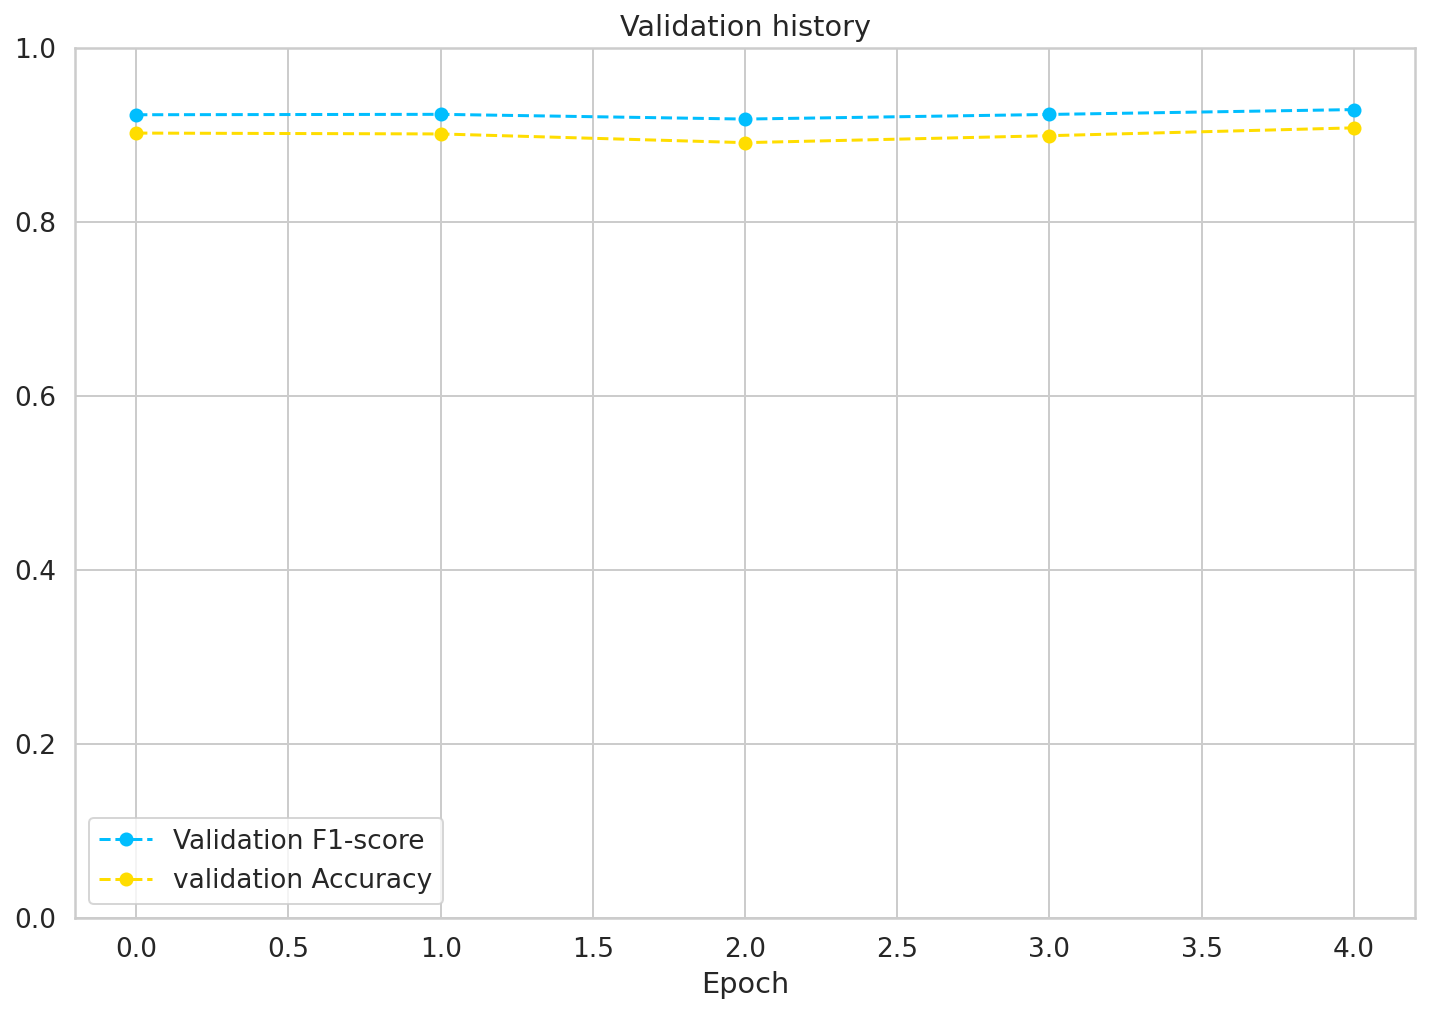

In [28]:
plt.plot([pt[0] for pt in val_metrics], "--o", label='Validation F1-score')
plt.plot([pt[1] for pt in val_metrics], "--o", label='validation Accuracy')

plt.title('Validation history')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

### Evaluation


In [29]:
gold_test_loss, gold_metrics = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

In [30]:
print("Gold test Loss : ", gold_test_loss)
print("Gold test F1-Score : ", gold_metrics[0])
print("Gold test Accuracy : ", gold_metrics[1])

Gold test Loss :  0.49766879100346706
Gold test F1-Score :  0.9452495974235104
Gold test Accuracy :  0.932


### Saving the model

In [31]:
run_iter = 5
save_dir = os.path.join('my_model_weights', 'run_{}'.format(run_iter))

if not os.path.exists(save_dir):
  print("Creating directory {}".format(save_dir))
  os.makedirs(save_dir)

save_path = os.path.join(save_dir, "epoch_{}".format(EPOCHS) + ".pth")
state = {
			'model': model.cpu().state_dict(),
			'optimizer': optimizer.state_dict(),
			'epoch': EPOCHS,
		}

torch.save(state, save_path)
model = model.to(device)

Creating directory my_model_weights/run_5


Saving weights in drive

In [32]:
copyfile('/content/my_model_weights/run_5/epoch_5.pth', '/content/gdrive/MyDrive/Roberta_model_with_aug_weights.pth')

'/content/gdrive/MyDrive/Roberta_model_with_aug_weights.pth'